In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import traceback

Helper functions for handling the interpolation of the ground truth

In [2]:
class Trace(object):
    def __init__(self, params):
        self.times = []
        self.params = {}
        for p in params:
            self.params[p] = []
    def frame(self, t, **params):
        self.times.append(t)
        for p in self.params.keys():
            if p not in params:
                self.params[p].append(self.params[p][-1])
            else:
                self.params[p].append(params[p])

    def get(self, t, p):
        if t < self.times[0]:
            return None
        elif t > self.times[-1]:
            return None
        else:
            return np.interp([t], self.times, self.params[p])[0]


def load_trace(fn):
    if not os.path.isfile(fn):
        return None
    else:
        with open(fn) as f:
            code = f.read()
        locals = dict()
        globals = dict(Trace=Trace)
        try:
            exec(code, globals, locals)
        except:
            traceback.print_exc()
            return None
        for k, v in locals.items():
            if isinstance(v, Trace):
                return v
        else:
            return None


Load in a data file and turn it into a big list of images and ground truth data

In [16]:
def extract_data(filename,        # filename to load data from 
                 dt,              # time between images to create (seconds)
                 decay_time=0.1,  # spike decay time (seconds)
                 t_start=None,    # time to start generating images (seconds)
                 t_end=None       # time to end generating images (seconds)
                ):
    packet_size = 8

    with open(filename, 'rb') as f:
        data = f.read()
    data = np.fromstring(data, np.uint8)

    trace = load_trace(filename+'.label')

    # find x and y values for events
    y = ((data[1::packet_size].astype('uint16')<<8) + data[::packet_size]) >> 2
    x = ((data[3::packet_size].astype('uint16')<<8) + data[2::packet_size]) >> 1
    # get the polarity (+1 for on events, -1 for off events)
    p = np.where((data[::packet_size] & 0x02) == 0x02, 1, -1)
    v = np.where((data[::packet_size] & 0x01) == 0x01, 1, -1)
    # find the time stamp for each event, in seconds from the start of the file
    t = data[7::packet_size].astype(np.uint32)
    t = (t << 8) + data[6::packet_size]
    t = (t << 8) + data[5::packet_size]
    t = (t << 8) + data[4::packet_size]
    #t = t - t[0]
    t = t.astype(float) / 1000000   # convert microseconds to seconds

    if t_start is None:
        t_start = 0
    if t_end is None:
        t_end = t[-1]

    image = np.zeros((180, 240), dtype=float)

    images = []
    targets = []
    times = []

    event_index = 0   # for keeping track of where we are in the file
    if t_start > 0:
        event_index = np.searchsorted(t, t_start)

    now = t_start

    event_dt = dt

    while now < t_end:
        xx = trace.get(now, 'x')
        yy = trace.get(now, 'y')
        rr = trace.get(now, 'r')
        valid = 1 if xx is not None else 0
        if xx is None:
            xx = -1
        if yy is None:
            yy = -1
        if rr is None:
            rr = -1

        if event_dt != 0:
            decay_scale = 1-np.abs(event_dt)/(np.abs(event_dt)+decay_time)
            image *= decay_scale

        if event_dt > 0:
            count = np.searchsorted(t[event_index:], now + event_dt)
            s = slice(event_index, event_index+count)

            dts = event_dt-(t[s]-now)
            image[y[s], x[s]] += p[s] * (1-dts / (dts+decay_time))
            event_index += count

        now += event_dt

        images.append(image.copy())
        targets.append([xx, yy, rr, valid])
        times.append(now)

    images = np.array(images)
    targets = np.array(targets)
    times = np.array(times)
    
    return times, images, targets



Let's look at the target data

/home/tcstewar/py3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


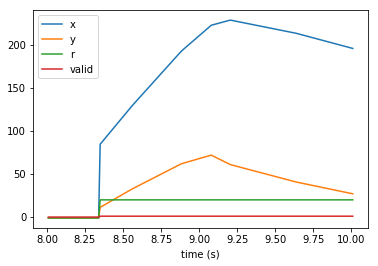

In [21]:
times, images, targets = extract_data(r'../davis_io/data/retinaTest5.events', dt=0.01, decay_time=0.01,
                                     t_start=8, t_end=10
                                     )
plt.plot(times, targets)
plt.xlabel('time (s)')
plt.legend(['x', 'y', 'r', 'valid'])

Let's look at the images

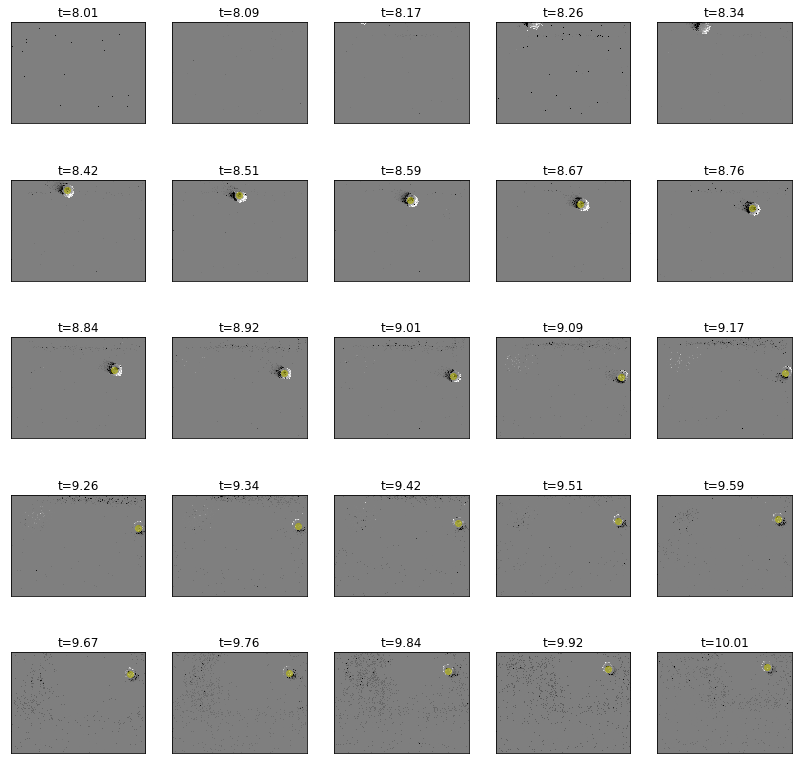

In [24]:
M = 5

indices = np.linspace(0, len(images)-1, M**2).astype(int)

plt.figure(figsize=(14,14))
for i in range(M):
    for j in range(M):
        plt.subplot(M, M, i*M+j+1)
        index = indices[i*M+j]
        plt.imshow(images[index], vmax=1, vmin=-1,
                   interpolation='none', cmap='binary')        
        plt.xlim(0, 240)
        plt.ylim(180, 0)
        plt.title('t=%g' % times[index])
        x, y, r, v = targets[index]
        if v:
            plt.scatter([x], [y], alpha=0.5, c='y')
        plt.xticks([])
        plt.yticks([])

Now let's train up the simplest machine learning system possible

In [26]:
import nengo

use_gabor = True
n_neurons = 2000
dimensions = 240*180

eval_points = images.reshape(-1, dimensions)   # set of input values

model = nengo.Network()
with model:
    if use_gabor:
        from nengo_extras.vision import Gabor, Mask
        encoders = Gabor().generate(n_neurons, (11, 11))
        encoders = Mask((240, 180)).populate(encoders, flatten=True)
    else:
        encoders = nengo.dists.UniformHypersphere(surface=True)

    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                         encoders=encoders,
                         intercepts=nengo.dists.CosineSimilarity(dimensions+2))
            
    result = nengo.Node(None, size_in=4)

    c = nengo.Connection(ens, result, 
                         eval_points=eval_points[::2],    # training data
                         function=targets[::2],           # training data
                         solver=nengo.solvers.LstsqL2(reg=0.03),
                         )
sim = nengo.Simulator(model)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

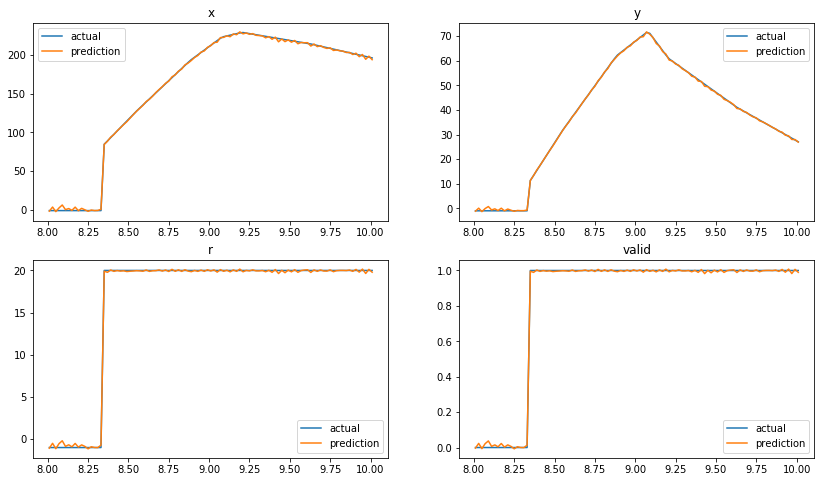

In [27]:
# performance on training data

# get the A matrix for the data to test on
_, a = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=eval_points[::2])    

# multiply A by D
output = np.dot(a, sim.data[c].weights.T)

plt.figure(figsize=(14,8))
for i, label in enumerate(['x', 'y', 'r', 'valid']):
    plt.subplot(2, 2, i+1)

    plt.plot(times[::2], targets[::2,i], label='actual')    
    plt.plot(times[::2], output[:,i], label='prediction')
    plt.legend()
    plt.title(label)
plt.show()

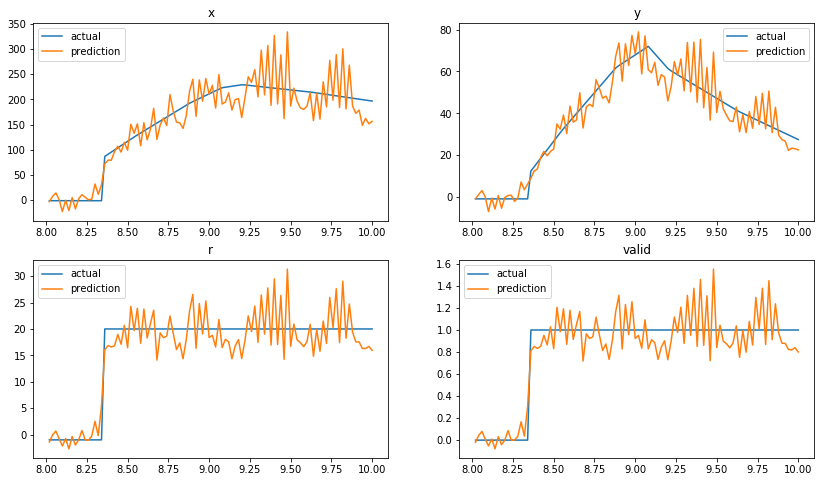

In [28]:
# testing data


# get the A matrix for the data to test on
_, a = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=eval_points[1::2])    

# multiply A by D
output = np.dot(a, sim.data[c].weights.T)

plt.figure(figsize=(14,8))
for i, label in enumerate(['x', 'y', 'r', 'valid']):
    plt.subplot(2, 2, i+1)

    plt.plot(times[1::2], targets[1::2,i], label='actual')    
    plt.plot(times[1::2], output[:,i], label='prediction')
    plt.legend()
    plt.title(label)
plt.show()